In [1]:
import pandas as pd
import numpy as np
import librosa
import glob
import gc
import time
import cv2
import math

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import timm
from tqdm.notebook import tqdm
import ast


import pandas.api.types
import kaggle_metric_utilities
import sklearn.metrics
from sklearn.model_selection import StratifiedKFold


# Config & Random Seed

In [2]:
from pathlib import Path

class Config:
    # Set up
    DEBUG_MODE = True
    SEED = 42 
    SAMPLE_RATE = 32000
    DATA_ROOT = '/kaggle/input/birdclef-2025'
    TRAIN_AUDIO_DIR = "/kaggle/input/birdclef-2025/train_audio"
    TRAIN_CSV = "/kaggle/input/birdclef-2025/train.csv"
    TEST_SOUNDSCAPES_DIR = "/kaggle/input/birdclef-2025/test_soundscapes"
    TRAIN_SOUNDSAPES_DIR = "/kaggle/input/birdclef-2025/train_soundscapes"
    
    # Data
    NUM_CLASSES = 206
    N_FFT = 1024
    HOP_LENGTH = 512
    N_MELS = 128
    F_MIN = 50
    F_MAX = 16000
    POWER = 2
    TARGET_DURATION = 60
    # TARGET_SHAPE = (256, 256)
    N_MAX = 50 if DEBUG_MODE else None
    
    # Model
    MODEL_NAME = "efficientnet_b0.ra4_e3600_r224_in1k"
    PRETRAINED = True
    IN_CHANNELS = 1
    DROPOUT = 0.1
    DROP_DEPTH = 0.2
    NUM_LAYERS = 2
    NUM_HEADS = 8

    # Training
    SEQ_LEN = 4 * 118
    FREEZE = False
    EPOCHS = 20
    NUM_FOLDS = 10
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 64
    LR = 1e-4


# Function to seed everything to ensure reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Change to true if input sizes are kept constant

    print(f"[INFO] Set Seed: {seed}")

cfg = Config()
seed_everything(cfg.SEED)

[INFO] Set Seed: 42


# Utilities

In [3]:
def audio_to_melspec(audio_data):
    # if np.isnan(audio_data).any():
    #     mean_signal = np.nanmean(audio_data)
    #     audio_data = np.nan_to_num(audio_data, nan=mean_signal)

    mel_spec = librosa.feature.melspectrogram(
        y=audio_data,
        sr=cfg.SAMPLE_RATE,
        n_fft=cfg.N_FFT,
        hop_length=cfg.HOP_LENGTH,
        n_mels=cfg.N_MELS,
        fmin=cfg.F_MIN,
        fmax=cfg.F_MAX,
        power=2.0
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
    
    return mel_spec_norm


class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Version of macro-averaged ROC-AUC score that ignores all classes that have no true positive labels.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if not pandas.api.types.is_numeric_dtype(submission.values):
        bad_dtypes = {x: submission[x].dtype  for x in submission.columns if not pandas.api.types.is_numeric_dtype(submission[x])}
        raise ParticipantVisibleError(f'Invalid submission data types found: {bad_dtypes}')

    solution_sums = solution.sum(axis=0)
    scored_columns = list(solution_sums[solution_sums > 0].index.values)
    assert len(scored_columns) > 0

    return kaggle_metric_utilities.safe_call_score(sklearn.metrics.roc_auc_score, solution[scored_columns].values, submission[scored_columns].values, average='macro')


def cal_score(labels, preds):
    labels = np.concatenate(labels)
    preds = np.concatenate(preds)

    labels = pd.DataFrame(labels > 0.5, columns = label_list)
    preds = pd.DataFrame(preds, columns = label_list)

    labels['id'] = np.arange(len(labels))
    preds['id'] = np.arange(len(preds))

    return score(labels, preds, "id")


def count_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    print(f"Trainable parameters: {trainable:,}")
    print(f"Non-trainable parameters: {non_trainable:,}")
    print(f"Total parameters: {trainable + non_trainable:,}")


# Exploratory Data Analysis

## Distribution & Statistics

In [4]:
# CSV structure

# primary_label: main species in the audio
# secondary_label: other species also occur in the audio (less confidence)
# filename: corresponding audio
# Others: don't care...
# ---------------------------------------------------------------------------------------------- #

data_df = pd.read_csv(cfg.TRAIN_CSV)

# create absolute path to filename
data_df['secondary_labels'] = data_df['secondary_labels'].apply(ast.literal_eval)

data_df.sample(10)

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
27685,yeofly1,[],['call'],yeofly1/XC250351.ogg,XC,4.0,https://xeno-canto.org/250351,-4.4010,-79.8540,Tolmomyias sulphurescens,Yellow-olive Flycatcher,Niels Krabbe,cc-by-sa 4.0
25019,whbman1,[],['mechanical sounds'],whbman1/XC268585.ogg,XC,5.0,https://xeno-canto.org/268585,-19.7323,-41.8141,Manacus manacus,White-bearded Manakin,Fabrice Schmitt,cc-by-nc-sa 4.0
96,21211,[],[''],21211/XC913998.ogg,XC,3.0,https://xeno-canto.org/913998,4.0946,-52.6862,Allobates femoralis,Spotted-thighed Poison Frog,Delaitre guillaume,cc-by-nc-sa 4.0
5771,bugtan,[],['flight call'],bugtan/XC480423.ogg,XC,5.0,https://xeno-canto.org/480423,-0.4383,-76.2791,Thraupis episcopus,Blue-gray Tanager,Jerome Fischer,cc-by-nc-sa 4.0
21879,strher,"[greani1, grekis]",['flight call'],strher/XC287867.ogg,XC,3.5,https://xeno-canto.org/287867,-22.4508,-42.7735,Butorides striata,Striated Heron,Jerome Fischer,cc-by-nc-sa 4.0
550,517119,[],[''],517119/iNat627646.ogg,iNat,0.0,https://static.inaturalist.org/sounds/627646.mp3,13.9296,-88.1021,Rhinella horribilis,Giant Toad,Carlos Funes,cc-by 4.0
1512,anhing,[],[''],anhing/iNat198504.ogg,iNat,0.0,https://static.inaturalist.org/sounds/198504.wav,24.7054,-81.3802,Anhinga anhinga,Anhinga,Nick Tepper,cc-by-nc 4.0
18405,smbani,[],['call'],smbani/XC461360.ogg,XC,3.0,https://xeno-canto.org/461360,-12.7210,-71.3649,Crotophaga ani,Smooth-billed Ani,Blair Jollands,cc-by-nc-sa 4.0
19569,socfly1,[],[''],socfly1/iNat360705.ogg,iNat,0.0,https://static.inaturalist.org/sounds/360705.wav,20.5138,-97.4619,Myiozetetes similis,Social Flycatcher,pozaricaalnatural,cc-by-nc 4.0
11127,grekis,[],[''],grekis/iNat356146.ogg,iNat,0.0,https://static.inaturalist.org/sounds/356146.wav,27.5389,-99.4917,Pitangus sulphuratus,Great Kiskadee,Diane Bricmont,cc-by-nc 4.0


In [5]:
# Null check
# ---------------------------------------------------------------------------------------------- #
print("Total data size:", len(data_df))
data_df.isnull().sum()

Total data size: 28564


primary_label         0
secondary_labels      0
type                  0
filename              0
collection            0
rating                0
url                   0
latitude            809
longitude           809
scientific_name       0
common_name           0
author                0
license               0
dtype: int64

**Comments:**
* The results from null check (above) indicates that all audios have **labels** => Don't need to discard any data items
* There are some missing values for **unimportant latitude and longitude columns**


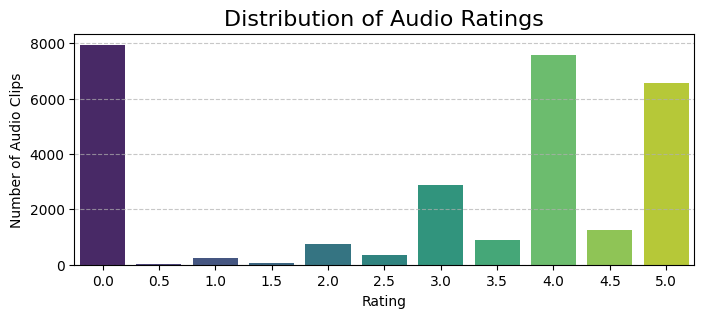

In [6]:
# Quick check distribution of ratings
# ---------------------------------------------------------------------------------------------- #
plt.figure(figsize=(8, 3))
sns.countplot(data=data_df, x='rating', palette='viridis', order=sorted(data_df['rating'].dropna().unique()))
plt.title('Distribution of Audio Ratings', fontsize=16)
plt.xlabel('Rating')
plt.ylabel('Number of Audio Clips')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Comments:**
* Audios' quality is good in general 

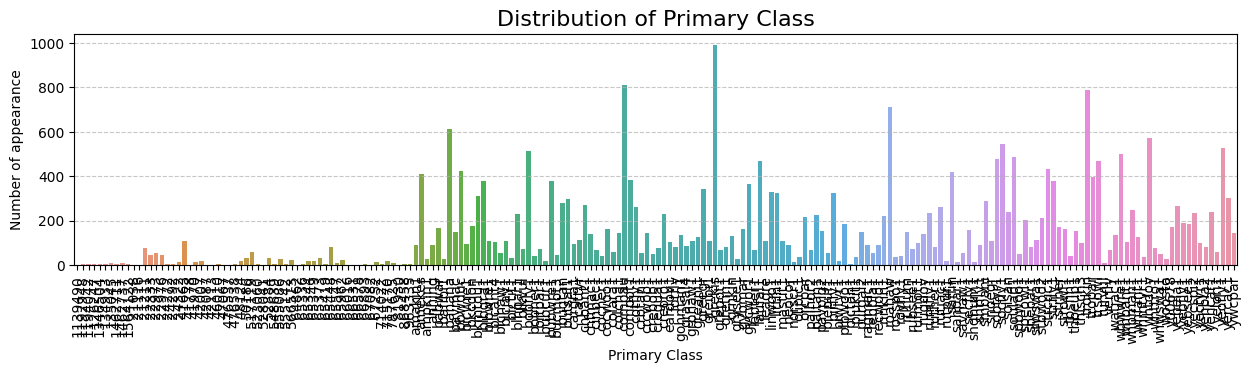

In [7]:
plt.figure(figsize=(15, 3))
sns.countplot(data_df, x="primary_label")
plt.title('Distribution of Primary Class', fontsize=16)
plt.xlabel('Primary Class')
plt.ylabel('Number of appearance')
plt.xticks(rotation = 90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
data_df['primary_label'].value_counts()

primary_label
grekis     990
compau     808
trokin     787
roahaw     709
banana     610
          ... 
476537       2
47067        2
42113        2
42087        2
1139490      2
Name: count, Length: 206, dtype: int64

**Comments:**
* Classes are highly imbalance 

## Checkout Spectrograms

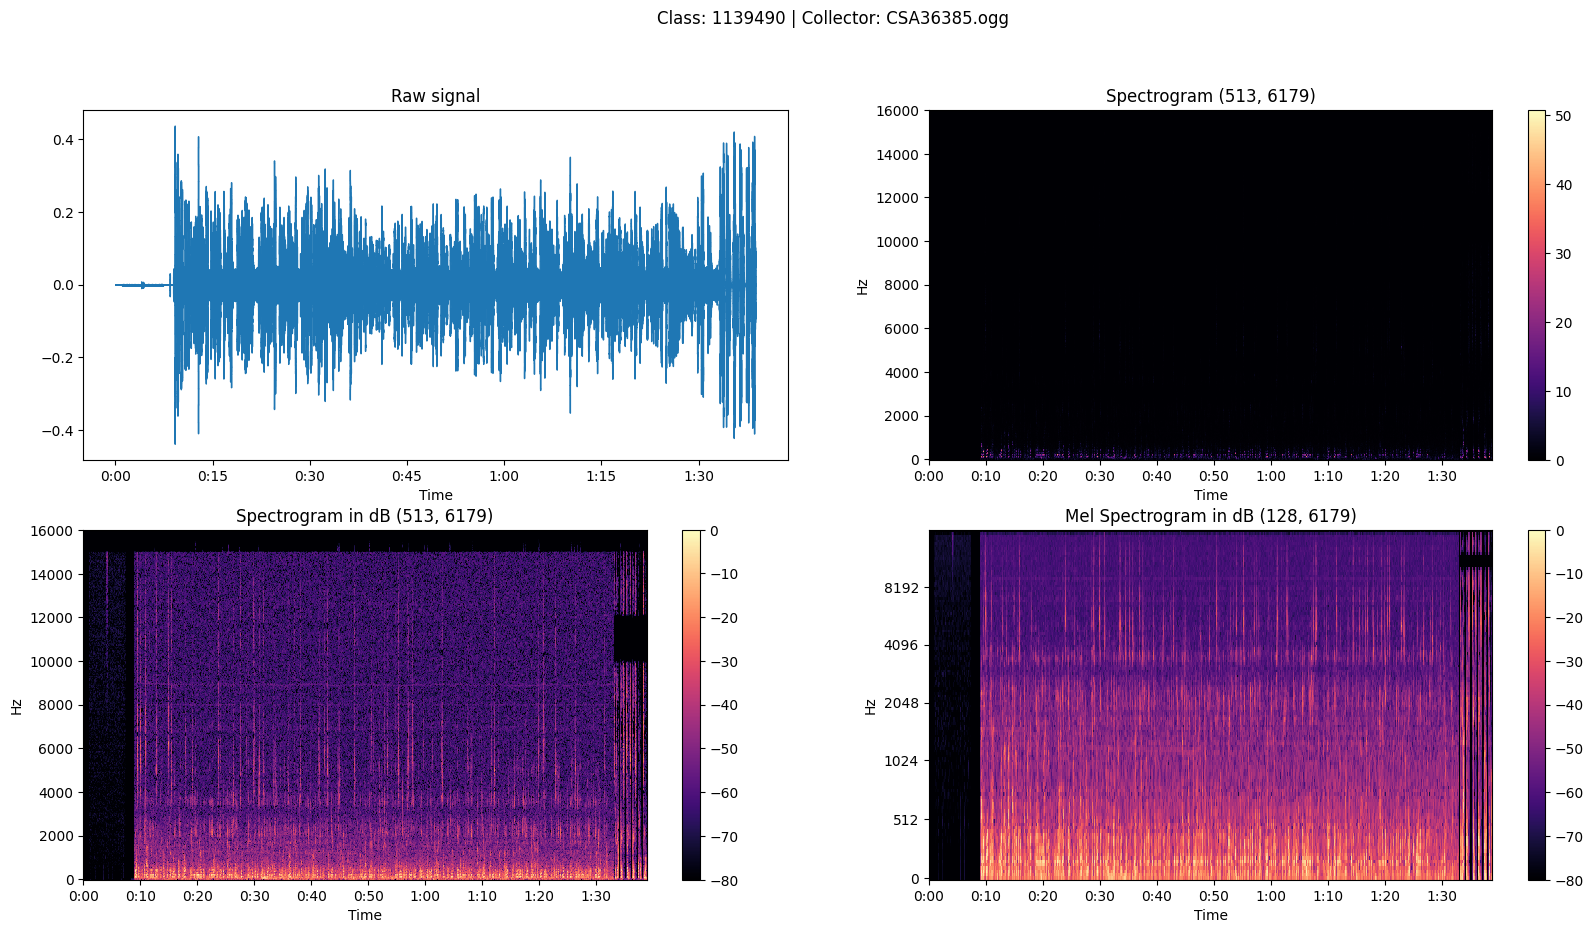

In [9]:
def show_signal(file_path):
    # /kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg
    cls, collector = file_path.split("/")[-2:]
    
    data, _ = librosa.load(file_path, sr=cfg.SAMPLE_RATE)
    # print("original length: ", len(data))
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle(f"Class: {cls} | Collector: {collector}")

    # ------ Plot raw signal------
    librosa.display.waveshow(data, sr=cfg.SAMPLE_RATE, ax=axes[0][0])
    axes[0][0].set_title("Raw signal")

    # ------Plot Fourier Transform signal------
    ft_amplitude = np.abs(librosa.stft(
        data,
        n_fft = cfg.N_FFT,
        hop_length = cfg.HOP_LENGTH
    ))
    # print("FT length: ", ft_amplitude.shape)

    im2 = librosa.display.specshow(
        ft_amplitude,
        sr = cfg.SAMPLE_RATE,
        hop_length = cfg.HOP_LENGTH,
        x_axis = "time",
        y_axis = "linear",
        ax = axes[0][1],
    )
    fig.colorbar(im2, ax=axes[0][1])
    axes[0][1].set_title(f"Spectrogram {ft_amplitude.shape}")
    
    # ------Transform from amplitude to dB------
    ft_db = librosa.amplitude_to_db(ft_amplitude, ref=np.max)
    im3 = librosa.display.specshow(
        ft_db,
        sr = cfg.SAMPLE_RATE,
        hop_length = cfg.HOP_LENGTH,
        x_axis = "time",
        y_axis = "linear",
        ax = axes[1][0],
    )
    fig.colorbar(im3, ax=axes[1][0])
    axes[1][0].set_title(f"Spectrogram in dB {ft_db.shape}")
    
    # ------Transform to mel spectrogram------
    mel_spec_db = audio_to_melspec(data)
    im4 = librosa.display.specshow(
        mel_spec_db,
        sr = cfg.SAMPLE_RATE,
        hop_length = cfg.HOP_LENGTH,
        x_axis = "time",
        y_axis = "mel",
        ax = axes[1][1],
    )
    fig.colorbar(im3, ax=axes[1][1])
    axes[1][1].set_title(f"Mel Spectrogram in dB {mel_spec_db.shape}")

    # print(ft)
    plt.show()

show_signal("/kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg")

# Data Processing

In [10]:
label_list = sorted(data_df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

In [11]:
taxonomy_df = pd.read_csv(f'{cfg.DATA_ROOT}/taxonomy.csv')
species_class_map = dict(zip(taxonomy_df['primary_label'], taxonomy_df['class_name']))

In [12]:
print(f'Found {len(label_list)} unique species')
working_df = data_df[['primary_label', 'secondary_labels', 'filename']].copy()

working_df['primary_target'] = working_df.primary_label.map(label2id)
working_df['secondary_target'] = working_df.secondary_labels.map(lambda x: [label2id[i] for i in x if (type(i) == str and i != '')])
working_df['filepath'] = working_df.filename.map(lambda x: os.path.join(cfg.TRAIN_AUDIO_DIR, x))
working_df['samplename'] = working_df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])
working_df['class'] = working_df.primary_label.map(lambda x: species_class_map.get(x, 'Unknown'))

total_samples = min(len(working_df), cfg.N_MAX or len(working_df))
print(f'Total samples to process: {total_samples} out of {len(working_df)} available')
print(f'Samples by class:')
print(working_df['class'].value_counts())

Found 206 unique species
Total samples to process: 50 out of 28564 available
Samples by class:
class
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64


In [13]:
working_df.sample(10)

,primary_label,secondary_labels,filename,primary_target,secondary_target,filepath,samplename,class
27517,yehcar1,[],yehcar1/iNat51284.ogg,201,[],/kaggle/input/birdclef-2025/train_audio/yehcar...,yehcar1-iNat51284,Aves
12423,laufal1,[],laufal1/XC357443.ogg,121,[],/kaggle/input/birdclef-2025/train_audio/laufal...,laufal1-XC357443,Aves
16290,roahaw,[],roahaw/iNat575684.ogg,144,[],/kaggle/input/birdclef-2025/train_audio/roahaw...,roahaw-iNat575684,Aves
644,566513,[],566513/iNat327841.ogg,38,[],/kaggle/input/birdclef-2025/train_audio/566513...,566513-iNat327841,Mammalia
21854,strher,[],strher/XC117050.ogg,174,[],/kaggle/input/birdclef-2025/train_audio/strher...,strher-XC117050,Aves
3805,blbgra1,[],blbgra1/iNat1282374.ogg,72,[],/kaggle/input/birdclef-2025/train_audio/blbgra...,blbgra1-iNat1282374,Aves
22498,trokin,[],trokin/XC131763.ogg,179,[],/kaggle/input/birdclef-2025/train_audio/trokin...,trokin-XC131763,Aves
20291,soulap1,[],soulap1/iNat565415.ogg,166,[],/kaggle/input/birdclef-2025/train_audio/soulap...,soulap1-iNat565415,Aves
22695,trokin,[],trokin/XC452712.ogg,179,[],/kaggle/input/birdclef-2025/train_audio/trokin...,trokin-XC452712,Aves
20125,soulap1,[],soulap1/XC798870.ogg,166,[],/kaggle/input/birdclef-2025/train_audio/soulap...,soulap1-XC798870,Aves


In [14]:
class BirdClefDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def process(self, file_path):
        audio_data, _ = librosa.load(file_path, sr=cfg.SAMPLE_RATE)
        
        target_samples = int(cfg.TARGET_DURATION * cfg.SAMPLE_RATE)
        
        if len(audio_data) < target_samples:
            n_copy = int(math.ceil(target_samples / len(audio_data)))
            if n_copy > 1:
                audio_data = np.concatenate([audio_data] * n_copy)
        
        cropped_audio = audio_data[:target_samples]
        cropped_audio = cropped_audio.reshape(-1, target_samples)
        
        mel_spec = audio_to_melspec(cropped_audio)
        return mel_spec

    def encode_label(self, primary_target, secondary_target):
        label = torch.zeros(cfg.NUM_CLASSES)
        label[primary_target] = 1.0
        label[secondary_target] = 1.0
        return label
        

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filepath = row['filepath']
        # print(filepath)

        label_id = self.encode_label(row['primary_target'], row['secondary_target'])
        mel_spec = torch.Tensor(self.process(filepath))
        return mel_spec, label_id
        

In [15]:
dataset = BirdClefDataset(working_df)

# Model

In [16]:
# All possible backbones

model_names = timm.list_models(pretrained=True)
model_names

['aimv2_1b_patch14_224.apple_pt',
 'aimv2_1b_patch14_336.apple_pt',
 'aimv2_1b_patch14_448.apple_pt',
 'aimv2_3b_patch14_224.apple_pt',
 'aimv2_3b_patch14_336.apple_pt',
 'aimv2_3b_patch14_448.apple_pt',
 'aimv2_huge_patch14_224.apple_pt',
 'aimv2_huge_patch14_336.apple_pt',
 'aimv2_huge_patch14_448.apple_pt',
 'aimv2_large_patch14_224.apple_pt',
 'aimv2_large_patch14_224.apple_pt_dist',
 'aimv2_large_patch14_336.apple_pt',
 'aimv2_large_patch14_336.apple_pt_dist',
 'aimv2_large_patch14_448.apple_pt',
 'bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patc

In [17]:
class TransformerHead(nn.Module):
    def __init__(self, emb_dim, max_seq_len, num_classes, num_layers=2, num_heads=8, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=num_heads,
            dim_feedforward=emb_dim * 2,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.PE = nn.Parameter(torch.zeros(1, 1 + max_seq_len, emb_dim))  # max_seq_len = H * W
        self.norm = nn.LayerNorm(emb_dim)
        self.head = nn.Linear(emb_dim, num_classes)
        
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.PE, std=0.02)

    def forward(self, x):
        B = x.size(0)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.PE[:, :x.size(1), :]
        x = self.transformer(x)
        x = self.norm(x[:, 0]) # Get [cls] token only
        return self.head(x)

        

class Classifier(nn.Module):
    def __init__(self, model_name=cfg.MODEL_NAME):
        super().__init__()
        self.backbone = timm.create_model(
            model_name,
            pretrained = cfg.PRETRAINED,
            in_chans = cfg.IN_CHANNELS,
            drop_rate = cfg.DROPOUT,
            drop_path_rate = cfg.DROP_DEPTH,
            num_classes = cfg.NUM_CLASSES,
        )
        self.emb_dim = self.backbone.get_classifier().in_features
        self.transformer_head = TransformerHead(
            emb_dim = self.emb_dim,
            max_seq_len = cfg.SEQ_LEN,
            num_classes = cfg.NUM_CLASSES,
            num_layers = cfg.NUM_LAYERS,
            num_heads = cfg.NUM_HEADS,
            dropout = cfg.DROPOUT,
        )
        
        self.backbone.reset_classifier(0, '')

    
    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), x.size(1), -1).permute(0, 2, 1) # (B, H*W, C)
        return self.transformer_head(x) # logits

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

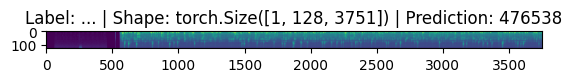

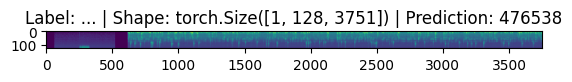

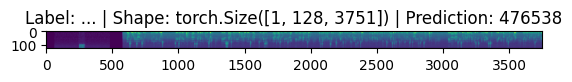

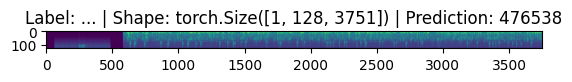

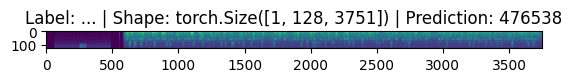

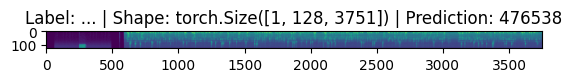

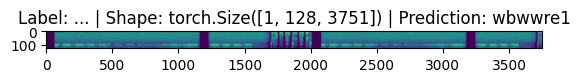

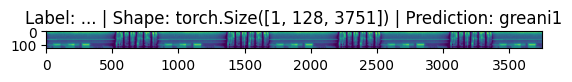

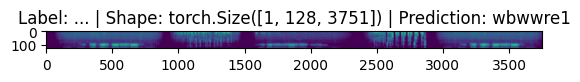

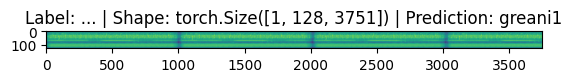

In [18]:
model = Classifier()
for i in range(10):
    x, y = dataset[i]

    model.eval()
    preds = model(x.unsqueeze(0))
    preds = torch.argmax(torch.softmax(preds, dim=1), dim=1).item()
    plt.imshow(np.transpose(x, (1, 2, 0)))
    plt.title(f"Label: ... | Shape: {x.shape} | Prediction: {id2label[preds]}")
    plt.show()
    

# Training

## Training ultilities

In [19]:
# Training ultilities
def train():
    overall_train_auc = []
    overall_val_auc = []
    overall_train_loss = []
    overall_val_loss = []
    
    SKFold = StratifiedKFold(
        n_splits = cfg.NUM_FOLDS,
        shuffle = True,
        random_state = cfg.SEED
    )
    
    for fold, (train_idx, val_idx) in enumerate(SKFold.split(X = working_df, y=working_df['primary_label'])):
        print(f"==========Fold {fold + 1}==========")
        best_val_auc, best_train_auc, best_val_loss, best_train_loss = train_one_fold(train_idx, val_idx, fold)
        
        overall_train_auc.append(best_train_auc)
        overall_val_auc.append(best_val_auc)
        overall_train_loss.append(best_train_loss)
        overall_val_loss.append(best_val_loss)

    print(f"=== Training {cfg.NUM_FOLDS} folds is done ===")
    print(f"| Overall train AUC: {np.mean(overall_train_auc):.4f}")
    print(f"| Overall val AUC: {np.mean(overall_val_auc):.4f}")
    print(f"| Overall train loss: {np.mean(overall_train_loss):.4f}")
    print(f"| Overall val loss: {np.mean(overall_val_loss):.4f}")


def train_one_fold(train_idx, val_idx, fold):
    train_df = working_df.iloc[train_idx].reset_index(drop=True)
    val_df = working_df.iloc[val_idx].reset_index(drop=True)
    print(f"Training size: {len(train_df)}")
    print(f"Testing size: {len(val_df)}")

    train_ds = BirdClefDataset(train_df)
    val_ds = BirdClefDataset(val_df)

    train_loader = DataLoader(
        train_ds, 
        batch_size=cfg.BATCH_SIZE, 
        num_workers=4, 
        drop_last=True,
        shuffle=True,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_ds, 
        batch_size=cfg.BATCH_SIZE, 
        num_workers=4, 
        drop_last=False,
        shuffle=False,
        pin_memory=True,
    )

    model = Classifier(cfg.MODEL_NAME)
    model.to(cfg.DEVICE)

    if cfg.FREEZE:
        for param in model.backbone.parameters():
            param.requires_grad = False
            
    print(f"Model running on: {next(model.parameters()).device}")
    count_parameters(model)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

    best_val_auc = 0
    best_train_auc = 0
    best_val_loss = 1e9
    best_train_loss = 1e9

    for epoch in range(cfg.EPOCHS):
        print(f"| Epoch {epoch}:")
        avg_train_loss, auc_train = train_one_epoch(model, criterion, optimizer, train_loader)
        avg_val_loss, auc_val = validate(model, criterion, val_loader)

        print(f"Fold {fold + 1} - Epoch {epoch}: Train loss {avg_train_loss:.4f} | ROC-AUC {auc_train:.4f}")
        print(f"Fold {fold + 1} - Epoch {epoch}: Val loss {avg_val_loss:.4f} | ROC-AUC {auc_val:.4f}")

        best_train_loss = min(best_train_loss, avg_train_loss)
        best_val_loss = min(best_val_loss, avg_val_loss)
        best_train_auc = max(best_train_auc, auc_train)

        if epoch == cfg.EPOCHS - 1:
            model_name_base = str(cfg.MODEL_NAME).split(".")[0]
            torch.save({'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        # 'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                        'epoch': epoch,
                        'val_auc': auc_val,
                        'train_auc': auc_train,
                        'val_loss': avg_val_loss,
                        'train_loss': avg_train_loss,
                        'cfg': cfg
                       }, f"fold_{fold}_epoch_last_{model_name_base}_valauc{auc_val:.4f}_valloss{avg_val_loss:.4f}.pth")
        if auc_val > best_val_auc:
            best_val_auc = auc_val
            model_name_base = str(cfg.MODEL_NAME).split(".")[0]
            print(f"===> New best AUC: {best_val_auc:.4f} at epoch {epoch}")
            torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    # 'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                    'epoch': epoch,
                    'val_auc': auc_val,
                    'train_auc': auc_train,
                    'val_loss': avg_val_loss,
                    'train_loss': avg_train_loss,
                    'cfg': cfg
                }, f"fold_{fold}_epoch_{epoch}_{model_name_base}_valauc{auc_val:.4f}_valloss{avg_val_loss:.4f}.pth")

    del train_df, val_df, train_ds, val_ds, train_loader, val_loader, model, criterion, optimizer
    gc.collect()
    torch.cuda.empty_cache()
    return best_val_auc, best_train_auc, best_val_loss, best_train_loss


def train_one_epoch(model, criterion, optimizer, train_loader):
    model.train()
    pred_train = []
    label_train = []
    train_losses = []

    train_pbar = tqdm(train_loader, desc="Training")
    for X, y in train_pbar:
        X, y = X.to(cfg.DEVICE), y.to(cfg.DEVICE)
        optimizer.zero_grad()

        logits = model(X)
        loss = criterion(logits, y)
        
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_pbar.set_postfix({"Train loss": loss.item()})

        # For ROC-AUC
        probs = torch.sigmoid(logits)
        pred_train.append(probs.detach().cpu().numpy())
        label_train.append(y.detach().cpu().numpy())
    
    avg_train_loss = np.mean(train_losses)
    auc_train = cal_score(label_train, pred_train)

    return avg_train_loss, auc_train

def validate(model, criterion, val_loader):
    model.eval()
    pred_val = []
    label_val = []
    val_losses = []

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc="Validating")
        for X, y in val_pbar:
            X, y = X.to(cfg.DEVICE), y.to(cfg.DEVICE)
            
            logits = model(X)
            loss = criterion(logits, y)
            
            val_losses.append(loss.item())
            val_pbar.set_postfix({"Val loss": loss.item()})

            # For ROC-AUC
            probs = torch.sigmoid(logits)
            pred_val.append(probs.detach().cpu().numpy())
            label_val.append(y.detach().cpu().numpy())

    avg_val_loss = np.mean(val_losses)
    auc_val = cal_score(label_val, pred_val)

    return avg_val_loss, auc_val


In [20]:
train()

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


==========Fold 1==========
Training size: 25707
Testing size: 2857
Model running on: cpu
Trainable parameters: 31,122,698
Non-trainable parameters: 0
Total parameters: 31,122,698
| Epoch 0:


Training:   0%|          | 0/401 [00:00<?, ?it/s]

KeyboardInterrupt: 